In [1199]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from data.encoder import Encoder
import missingno as msno
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from analyzer.stat_criterion.stat_criteria import StatCriteria
from analyzer.metric import MetricCalculator
from data.io import Reader, Saver
from data.plot import Drawer
import seaborn as sns
from analyzer.stat_criterion.analyser_timeseries_custom import AnalyserTimeSeriesCustom
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch

# Постановка задачи

Коэффициент Джини (индекс Джини, или «индекс справедливости») — показатель, отражающий степень неравенства в распределении доходов внутри различных групп населения. Коэффициент в 1912 году разработал итальянский статистик Коррадо Джини. Показатель принимает значения от 0 (в случае абсолютного равенства) до 1 (в случае абсолютного неравенства).

1. Предскажите коэффициент Джини для России на 2021
2. Найдите страну на постсоветском пространстве у которой коэф.Джини наименьший
3. Определите для каждого десятилетия средний уровень коэф.Джини для всех стран и постройте столбчатую диаграмму
4. Добавить столбец регион (подумайте как это сделать проще всего)
5. Определите изменение коэффицинта Джини по регионам
6. Найдите страну с наименьшим коэф.Джини на протяжении всей истории наблюдений (есть ли такая вообще)

датасет: https://raw.githubusercontent.com/Semendyeav/datasets/main/PDA210_Test_4.csv

# Выгрузка и проверка целостности датасета

In [1150]:
# читаем датасет в память из внешнего источника
df_original = Reader.read_csv("https://raw.githubusercontent.com/Semendyeav/datasets/main/PDA210_Test_4.csv")
Saver.save_csv(df_original, "PDA210_Control_Test_4", False)
df = df_original.copy().reset_index(drop=True)
df['value'] = df['value'] / 100
df.head(10)

Файл успешно сохранён: ./dataset/PDA210_Control_Test_4.csv


,country_code,country_name,year,value
0,BEN,Benin,2003,0.386
1,LBR,Liberia,2016,0.353
2,MUS,Mauritius,2006,0.357
3,PER,Peru,1997,0.533
4,MRT,Mauritania,1995,0.377
5,CHE,Switzerland,2010,0.326
6,PRT,Portugal,2004,0.389
7,GEO,Georgia,2016,0.366
8,RWA,Rwanda,2000,0.485
9,ARG,Argentina,2012,0.413


In [1151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896 entries, 0 to 1895
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  1896 non-null   object 
 1   country_name  1896 non-null   object 
 2   year          1896 non-null   int64  
 3   value         1896 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 59.4+ KB


## пропуски в данных

In [1152]:
# посмотрим на пропуски в данных
df.isna().sum()

country_code    0
country_name    0
year            0
value           0
dtype: int64

<Axes: >

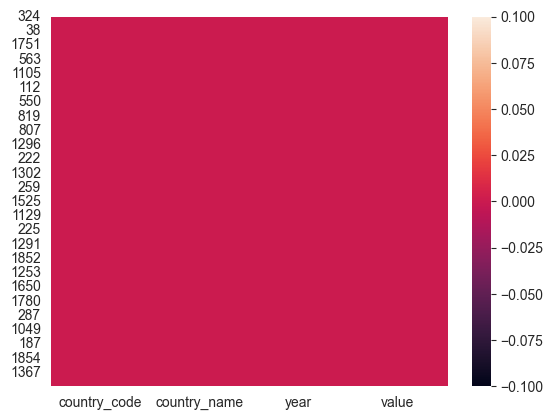

In [1153]:
# Посмотрим на пропуски
sns.heatmap(df.sort_values(by='year').isna())

<Axes: >

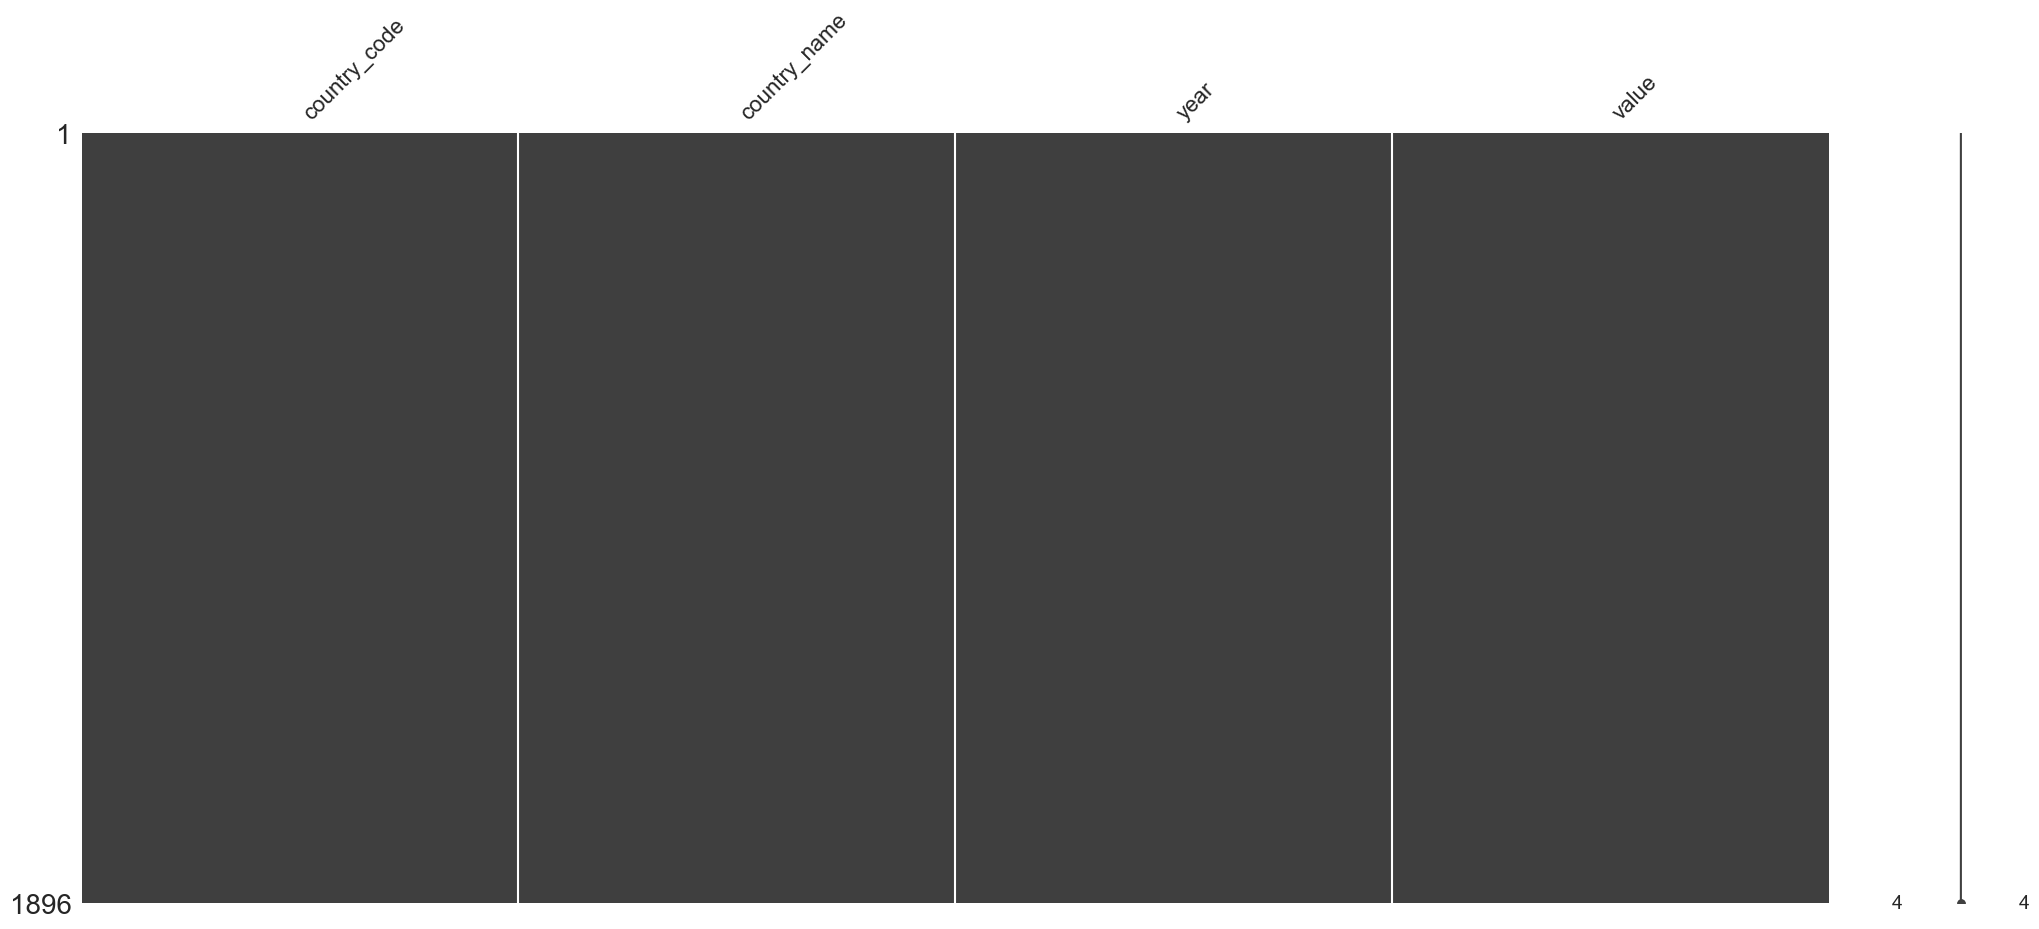

In [1154]:
# Посмотрим на пропуски
msno.matrix(df)

## выявление неестественных значений

In [1155]:
# Посмотрим статистику о датасете
df.describe()

,year,value
count,1896.000000,1896.000000
mean,2006.275844,0.381793
std,9.348789,0.090776
min,1967.000000,0.202000
25%,2000.750000,0.312000
50%,2008.000000,0.361000
75%,2014.000000,0.441000
max,2021.000000,0.658000


# Ответы на вопросы

## предскажите коэффициент Джини для России на 2021

In [1156]:
mask = df['country_name'] == 'Russian Federation'

df_RF = df[mask].sort_values(by='year', ascending=False)
df_RF.head(10)

,country_code,country_name,year,value
1066,RUS,Russian Federation,2020,0.360
1019,RUS,Russian Federation,2019,0.377
1666,RUS,Russian Federation,2018,0.375
1424,RUS,Russian Federation,2017,0.372
709,RUS,Russian Federation,2016,0.368
1207,RUS,Russian Federation,2015,0.377
1023,RUS,Russian Federation,2014,0.399
1862,RUS,Russian Federation,2013,0.409
670,RUS,Russian Federation,2012,0.407
1574,RUS,Russian Federation,2011,0.397


Прогноз на следующий год: 0.3548


C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

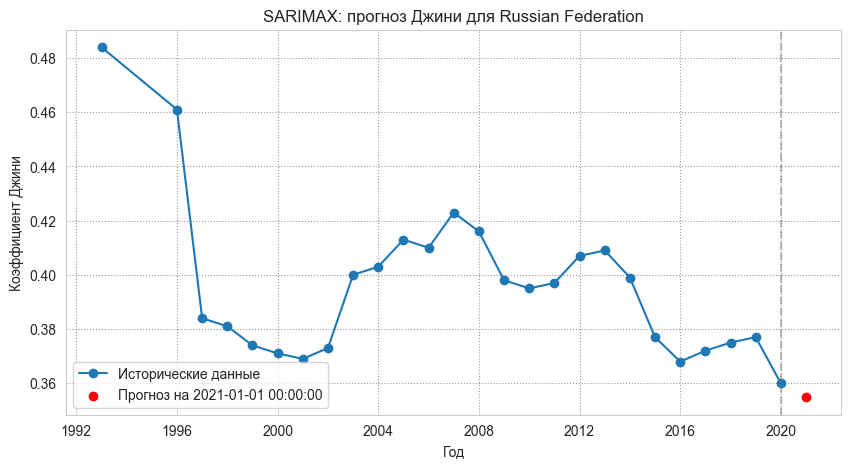

In [1157]:
df_RF.drop(columns=['country_code', 'country_name'], axis=1, inplace=True)

df_RF.sort_values('year', inplace=True)
df_RF['year'] = pd.to_datetime(df_RF['year'], format="%Y")
df_RF.set_index('year', inplace=True)
series = df_RF['value']

series.index = pd.to_datetime(series.index)

model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
results = model.fit(disp=False)

# Прогноз на 1 год вперёд
forecast = results.get_forecast(steps=1)
predicted_value = forecast.predicted_mean.iloc[0]
conf_int = forecast.conf_int()

print(f"Прогноз на следующий год: {predicted_value:.4f}")

x_forecast = series.index[-1] + pd.DateOffset(years=1)

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(series, label="Исторические данные", marker='o')
plt.axvline(series.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.scatter(x_forecast, predicted_value, color='red', label=f"Прогноз на {x_forecast}")
plt.legend()
plt.title(f"SARIMAX: прогноз Джини для Russian Federation")
plt.xlabel("Год")
plt.ylabel("Коэффициент Джини")
plt.show()

## найдите страну на постсоветском пространстве у которой коэф.Джини наименьший

In [1158]:
# находим данные на последний год
gini_by_country = df.groupby('country_name')['value'].last().sort_values().reset_index()
gini_by_country.head(10)

,country_name,value
0,Belarus,0.244
1,Slovenia,0.248
2,Belgium,0.250
3,Slovak Republic,0.258
4,Czechia,0.261
5,Ukraine,0.266
6,Moldova,0.270
7,Bangladesh,0.276
8,Timor-Leste,0.278
9,Hungary,0.279


In [1159]:
post_soviet_countries = [
    "Russian Federation",
    "Ukraine",
    "Belarus",
    "Kazakhstan",
    "Armenia",
    "Georgia",
    "Azerbaijan",
    "Uzbekistan",
    "Kyrgyzstan",
    "Tajikistan",
    "Turkmenistan",
    "Moldova",
    "Lithuania",
    "Latvia",
    "Estonia",
]

mask = gini_by_country['country_name'].isin(post_soviet_countries)
gini_post_soviet = gini_by_country[mask].sort_values(by = 'value')

gini_post_soviet.head(10)

,country_name,value
0,Belarus,0.244
5,Ukraine,0.266
6,Moldova,0.270
11,Kazakhstan,0.282
22,Estonia,0.304
24,Armenia,0.306
37,Tajikistan,0.322
55,Lithuania,0.344
58,Azerbaijan,0.347
62,Latvia,0.350


## определите для каждого десятилетия средний уровень коэф.Джини для всех стран и постройте столбчатую диаграмму

In [1160]:
df['decade'] = (df['year'] // 10) * 10

In [1161]:
gini_decade_country = df.groupby(['country_name', 'decade'])['value'].mean().reset_index()

gini_decade_country.head(10)

,country_name,decade,value
0,Albania,1990,0.270000
1,Albania,2000,0.307667
2,Albania,2010,0.320143
3,Algeria,1980,0.402000
4,Algeria,1990,0.353000
5,Algeria,2010,0.276000
6,Angola,2000,0.473500
7,Angola,2010,0.513000
8,Argentina,1980,0.429667
9,Argentina,1990,0.479000


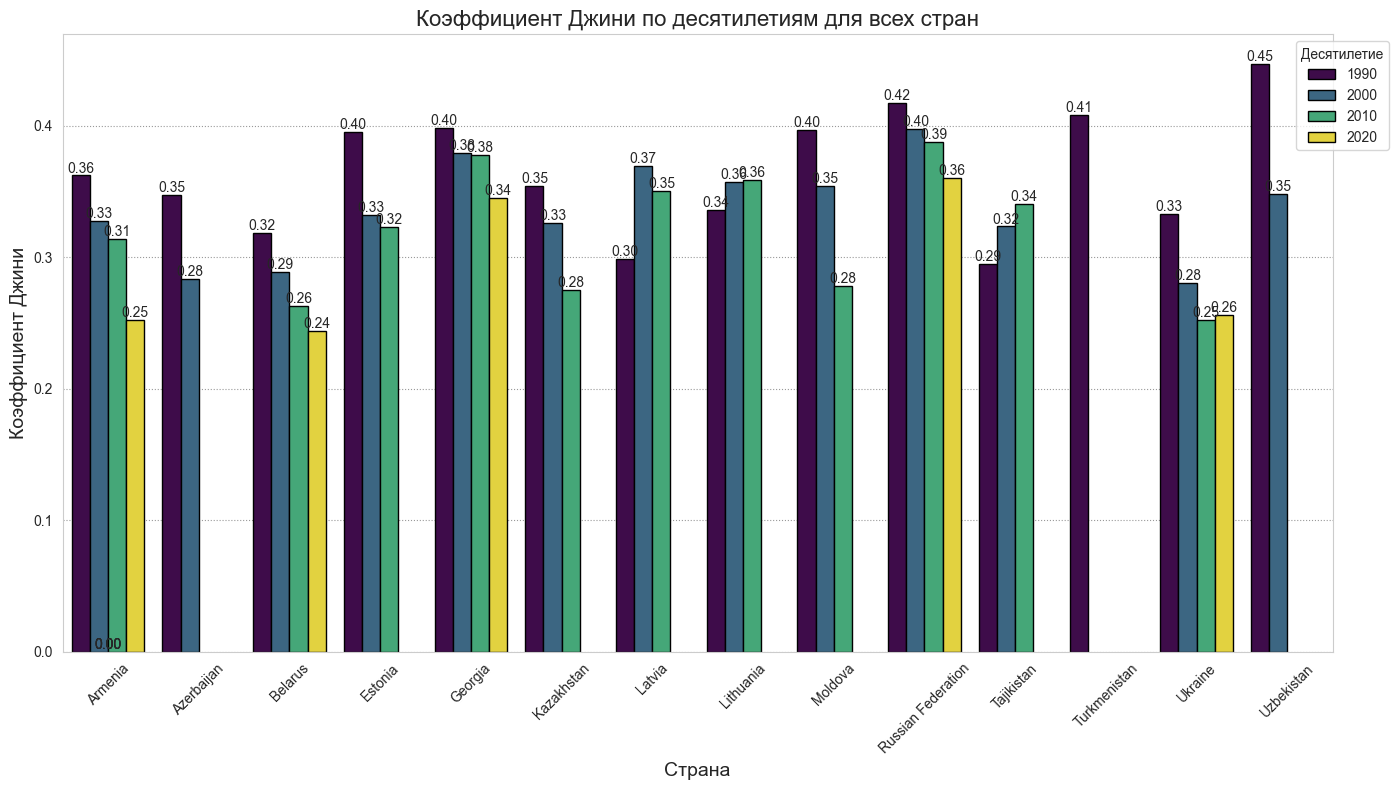

In [1162]:
plt.figure(figsize=(14, 8))

mask = gini_decade_country['country_name'].isin(post_soviet_countries)

sns.barplot(
    data=gini_decade_country[mask],
    x='country_name',
    y='value',
    hue='decade',
    palette='viridis',
    edgecolor='black'
)

plt.title('Коэффициент Джини по десятилетиям для всех стран', fontsize=16)
plt.xlabel('Страна', fontsize=14)
plt.ylabel('Коэффициент Джини', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Десятилетие', bbox_to_anchor=(1.05, 1))

# Добавляем подписи значений
for p in plt.gca().patches:
    plt.gca().annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', xytext=(0, 5), textcoords='offset points'
    )

plt.tight_layout()
plt.show()

## добавить столбец регион (подумайте как это сделать проще всего)

In [1163]:
# url = "https://restcountries.com/v3.1/all"
#
# try:
#     response = requests.get(url, timeout=10, verify=False)
#     response.raise_for_status()
#     data = response.json()
#
#     with open("countries.json", "w", encoding="utf-8") as f:
#         json.dump(data, f, ensure_ascii=False, indent=2)
#
# except requests.exceptions.RequestException as e:
#     print(f"Не удалось загрузить данные с API: {e}")

In [1164]:
with open('countries.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

country_region_mapping = {
    country.get('cca3', ''): country.get('region', 'Unknown')
    for country in data
}

def get_region(country_name):
    return country_region_mapping.get(country_name, "Unknown")

df['region'] = df['country_code'].apply(get_region)
df.head(10)

,country_code,country_name,year,value,decade,region
0,BEN,Benin,2003,0.386,2000,Africa
1,LBR,Liberia,2016,0.353,2010,Africa
2,MUS,Mauritius,2006,0.357,2000,Africa
3,PER,Peru,1997,0.533,1990,Americas
4,MRT,Mauritania,1995,0.377,1990,Africa
5,CHE,Switzerland,2010,0.326,2010,Europe
6,PRT,Portugal,2004,0.389,2000,Europe
7,GEO,Georgia,2016,0.366,2010,Asia
8,RWA,Rwanda,2000,0.485,2000,Africa
9,ARG,Argentina,2012,0.413,2010,Americas


In [1165]:
mask = df['region'] == 'Unknown'
df[mask]['country_name'].unique()

array(['Kosovo'], dtype=object)

In [1166]:
mask = df['country_name'] == 'Kosovo'
df['region'] = df['region'].mask(mask, 'Europe')

In [1167]:
mask = df['region'] == 'Unknown'
df[mask]['country_name'].unique()

array([], dtype=object)

## определите изменение коэффицинта Джини по регионам

In [1168]:
gini_region = df.groupby(['region', 'year'])['value'].mean().reset_index()

gini_region.head(10)

,region,year,value
0,Africa,1980,0.468000
1,Africa,1984,0.392000
2,Africa,1985,0.454500
3,Africa,1986,0.470000
4,Africa,1987,0.399000
5,Africa,1988,0.377000
6,Africa,1989,0.444000
7,Africa,1990,0.371333
8,Africa,1991,0.470200
9,Africa,1992,0.448571


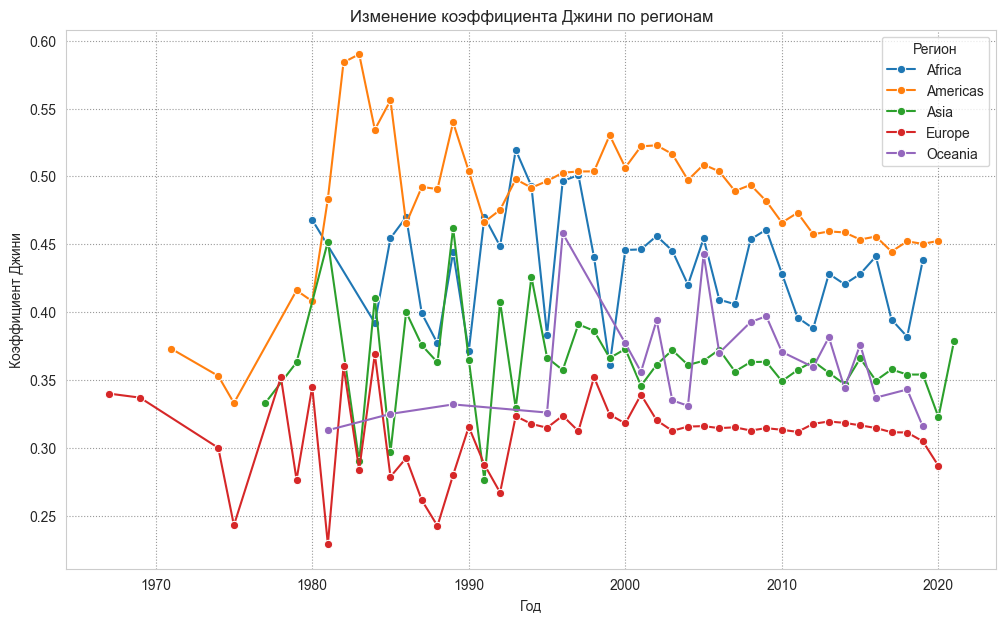

In [1169]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=gini_region, x='year', y='value', hue='region', marker='o')

plt.title('Изменение коэффициента Джини по регионам')
plt.xlabel('Год')
plt.ylabel('Коэффициент Джини')
plt.legend(title='Регион')
plt.grid(True)
plt.show()

## найдите страну с наименьшим коэф.Джини на протяжении всей истории наблюдений (есть ли такая вообще)

In [1170]:
df.sort_values(by='value', ascending=True)

,country_code,country_name,year,value,decade,region
1604,SVK,Slovak Republic,1992,0.202,1990,Europe
1099,CZE,Czechia,1992,0.207,1990,Europe
869,HUN,Hungary,1987,0.210,1980,Europe
430,FIN,Finland,1987,0.222,1980,Europe
1597,HRV,Croatia,1988,0.228,1980,Europe
...,...,...,...,...,...,...
1546,BRA,Brazil,1989,0.633,1980,Americas
392,ZAF,South Africa,2010,0.634,2010,Africa
817,BWA,Botswana,2002,0.647,2000,Africa
1108,ZAF,South Africa,2005,0.648,2000,Africa


# Анализ взаимосвязей в данных

In [1171]:
df.drop(columns='country_name', axis=1, inplace=True)
df.drop(columns='region', axis=1, inplace=True)

## построение мульти-временного датасета

In [1172]:
df_pivot = df.pivot(index='year', columns='country_code', values='value')
df_pivot.columns = [f'value_{col}' for col in df_pivot.columns]
df = df_pivot.reset_index()

df.head(10)

,year,value_AGO,value_ALB,value_ARE,value_ARG,value_ARM,value_AUS,value_AUT,value_AZE,value_BDI,...,value_UZB,value_VEN,value_VNM,value_VUT,value_WSM,value_XKX,value_YEM,value_ZAF,value_ZMB,value_ZWE
0,1967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1980,NaN,NaN,NaN,0.408,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1981,NaN,NaN,NaN,NaN,NaN,0.313,NaN,NaN,NaN,...,NaN,0.556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## подготовка временного ряда

In [1173]:
target = 'value_RUS'
period = 10

In [1174]:
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.set_index('year', inplace=True)
df.sort_index(inplace=True)

In [1175]:
df = df.dropna(axis=1, how='all')

In [1176]:
df.head(10)

,value_AGO,value_ALB,value_ARE,value_ARG,value_ARM,value_AUS,value_AUT,value_AZE,value_BDI,value_BEL,...,value_UZB,value_VEN,value_VNM,value_VUT,value_WSM,value_XKX,value_YEM,value_ZAF,value_ZMB,value_ZWE
year,,,,,,,,,,,,,,,,,,,,,
1967-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1977-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-01,NaN,NaN,NaN,0.408,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## проверка на стационарность

In [1177]:
def test_stationarity(series, name=None):
    if len(series.dropna()) < 4:
        print(f"{name}: выборка слишком мала для применения теста ADF.")
        return False

    result = adfuller(series.dropna(), autolag='AIC')
    if result[1] < 0.05:
        print(f"{name}: ряд стационарен.")
    else:
        print(f"{name}: ряд нестационарен.")
    return True


In [1178]:
valid_columns = []

for column in df.columns:
    if test_stationarity(df[column], name=column):
        valid_columns.append(column)

df = df[valid_columns]

df.head(10)

value_AGO: выборка слишком мала для применения теста ADF.
value_ALB: ряд стационарен.
value_ARE: выборка слишком мала для применения теста ADF.
value_ARG: ряд нестационарен.
value_ARM: ряд нестационарен.
value_AUS: ряд нестационарен.
value_AUT: ряд нестационарен.
value_AZE: ряд нестационарен.
value_BDI: ряд стационарен.
value_BEL: ряд стационарен.
value_BEN: ряд нестационарен.
value_BFA: ряд нестационарен.
value_BGD: ряд нестационарен.
value_BGR: ряд стационарен.
value_BIH: ряд стационарен.
value_BLR: ряд нестационарен.
value_BLZ: ряд нестационарен.
value_BOL: ряд нестационарен.
value_BRA: ряд нестационарен.
value_BTN: ряд нестационарен.
value_BWA: ряд нестационарен.
value_CAF: выборка слишком мала для применения теста ADF.
value_CAN: ряд стационарен.
value_CHE: ряд нестационарен.
value_CHL: ряд нестационарен.
value_CHN: ряд нестационарен.
value_CIV: ряд нестационарен.
value_CMR: ряд нестационарен.
value_COD: выборка слишком мала для применения теста ADF.
value_COG: выборка слишком мал

,value_ALB,value_ARG,value_ARM,value_AUS,value_AUT,value_AZE,value_BDI,value_BEL,value_BEN,value_BFA,...,value_UGA,value_UKR,value_URY,value_USA,value_UZB,value_VEN,value_VNM,value_XKX,value_ZAF,value_ZMB
year,,,,,,,,,,,,,,,,,,,,,
1967-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.353,NaN,NaN,NaN,NaN,NaN,NaN
1975-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1977-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.345,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-01,NaN,0.408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1179]:
def test_kpss(series, name=None):
    if len(series.dropna()) < 4:
        print(f"{name}: выборка слишком мала для применения теста KPSS.")
        return

    result = kpss(series.dropna(), regression='c', nlags='auto')
    # print(f"{name}: p-value = {result[1]:.3f}")
    if result[1] < 0.05:
        print(f"{name}: ряд не стационарен.")
    else:
        print(f"{name}: ряд стационарен.")
    return

for column in df.columns:
    test_kpss(df[column], name=column)

value_ALB: ряд стационарен.
value_ARG: ряд стационарен.
value_ARM: ряд стационарен.
value_AUS: ряд не стационарен.
value_AUT: ряд стационарен.
value_AZE: ряд стационарен.
value_BDI: ряд не стационарен.
value_BEL: ряд стационарен.
value_BEN: ряд стационарен.
value_BFA: ряд стационарен.
value_BGD: ряд стационарен.
value_BGR: ряд не стационарен.
value_BIH: ряд стационарен.
value_BLR: ряд не стационарен.
value_BLZ: ряд стационарен.
value_BOL: ряд не стационарен.
value_BRA: ряд не стационарен.
value_BTN: ряд стационарен.
value_BWA: ряд стационарен.
value_CAN: ряд стационарен.
value_CHE: ряд стационарен.
value_CHL: ряд не стационарен.
value_CHN: ряд стационарен.
value_CIV: ряд стационарен.
value_CMR: ряд стационарен.
value_COL: ряд не стационарен.
value_CRI: ряд не стационарен.
value_CYP: ряд стационарен.
value_CZE: ряд стационарен.
value_DEU: ряд не стационарен.
value_DJI: ряд стационарен.
value_DNK: ряд не стационарен.
value_DOM: ряд не стационарен.
value_ECU: ряд не стационарен.
value_EGY

C:\Users\Tikhon\AppData\Local\Temp\ipykernel_16052\1816634638.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\Tikhon\AppData\Local\Temp\ipykernel_16052\1816634638.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\Tikhon\AppData\Local\Temp\ipykernel_16052\1816634638.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags='auto')
C:\Users\Tikhon\AppData\Local\Temp\ipykernel_16052\1816634638.py:6: InterpolationWarning: The test statist

## интерполяция пропусков

In [1180]:
df.isna().sum()

value_ALB    39
value_ARG    18
value_ARM    29
value_AUS    38
value_AUT    28
             ..
value_VEN    37
value_VNM    38
value_XKX    38
value_ZAF    43
value_ZMB    41
Length: 125, dtype: int64

In [1181]:
df = df.interpolate(method='linear', limit_direction='both')

In [1182]:
df.isna().sum()

value_ALB    0
value_ARG    0
value_ARM    0
value_AUS    0
value_AUT    0
            ..
value_VEN    0
value_VNM    0
value_XKX    0
value_ZAF    0
value_ZMB    0
Length: 125, dtype: int64

## декомпозиция

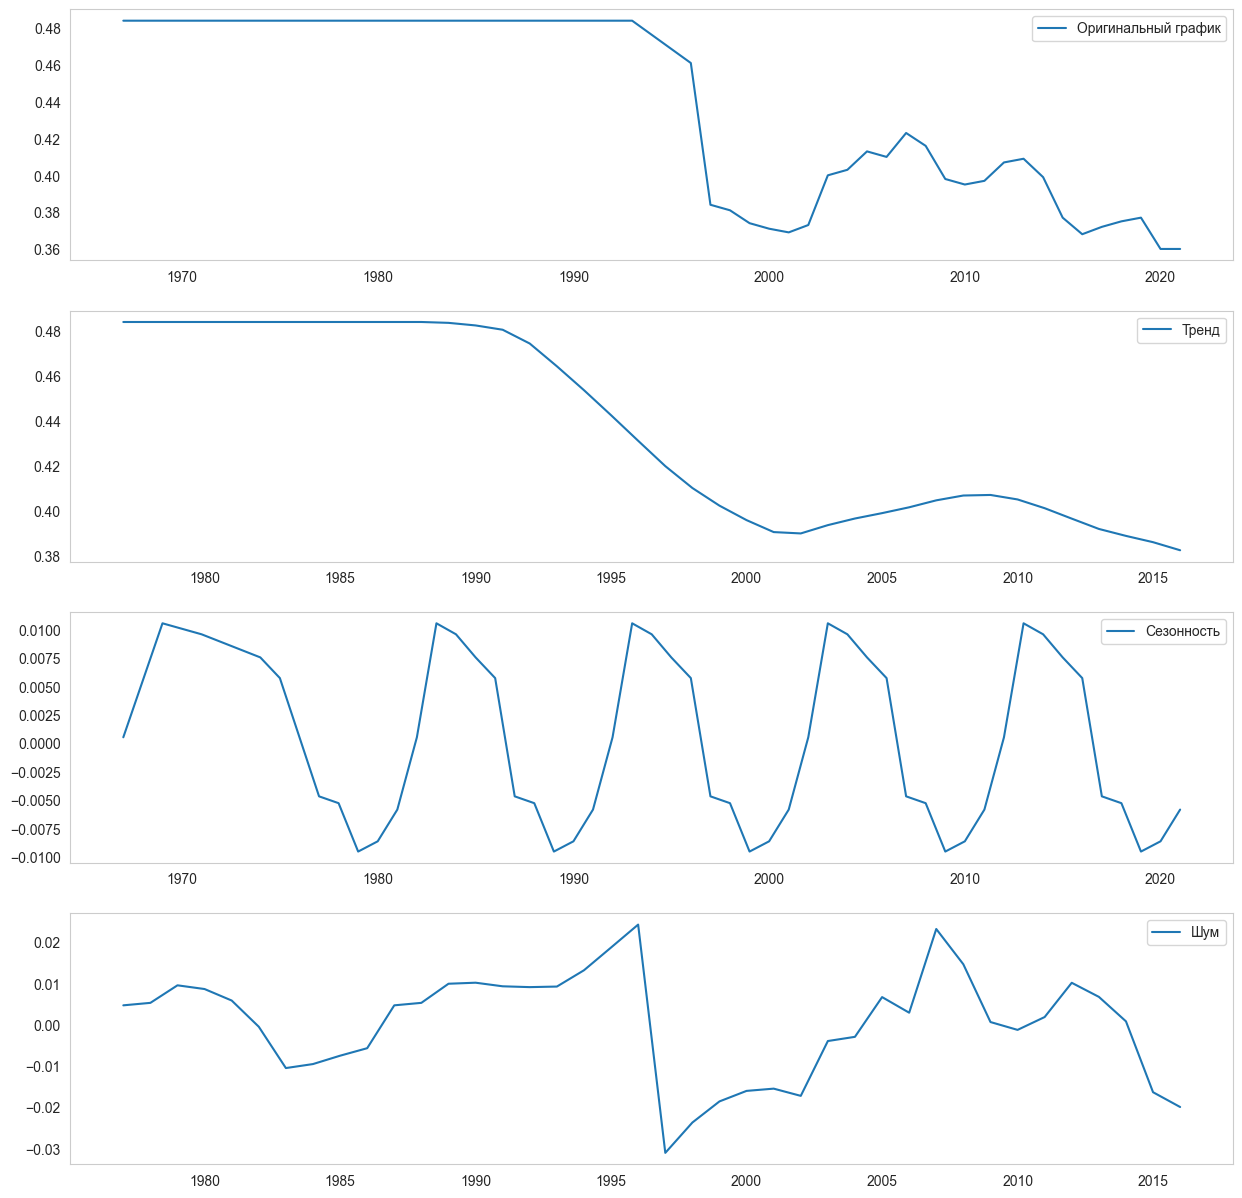

In [1183]:
analysis = AnalyserTimeSeriesCustom(df[target])
analysis.decompositon(model='add', period=period)

## автокорреляционное разложение

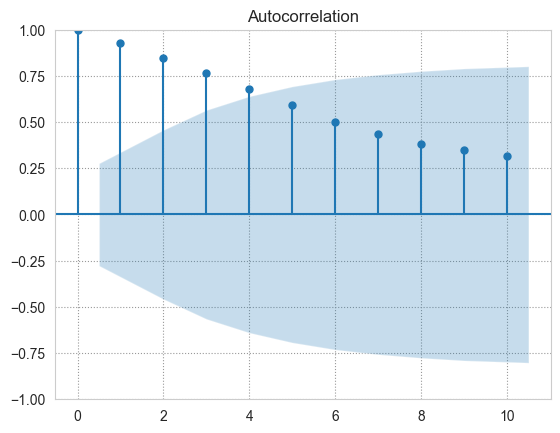

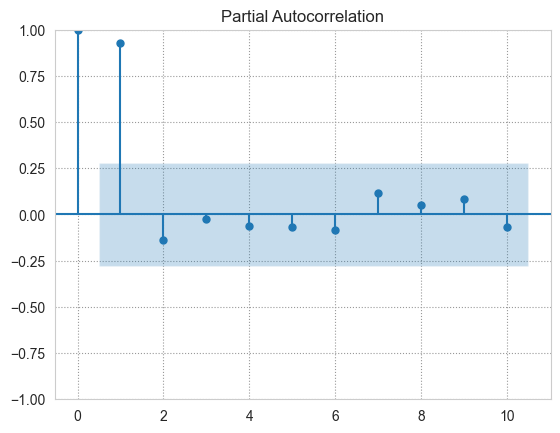

In [1184]:
analysis.auto_correlation(period)

# Нахождение оптимальной модели

## модель VARMAX

In [1186]:
separate_point = int(len(df) * 0.75)

train_data = df.iloc[:separate_point]
test_data = df.iloc[separate_point:]

endog_train = train_data[['value_RUS', 'value_USA', 'value_CHN']]
endog_test = test_data[['value_RUS', 'value_USA', 'value_CHN']]

model = VARMAX(endog=endog_train, order=(1, 1))
model_fitted = model.fit(disp=True)

forecast_interval = len(test_data)
forecast = model_fitted.forecast(steps=forecast_interval) 
print(forecast)

C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


    value_RUS  value_USA  value_CHN
37   0.421073   0.409535   0.433834
38   0.429021   0.408882   0.430101
39   0.435854   0.408382   0.426201
40   0.441495   0.408021   0.422279
41   0.445920   0.407783   0.418461
42   0.449152   0.407648   0.414851
43   0.451250   0.407597   0.411531
44   0.452309   0.407610   0.408564
45   0.452443   0.407669   0.405989
46   0.451787   0.407754   0.403828
47   0.450482   0.407850   0.402085
48   0.448673   0.407942   0.400748
49   0.446504   0.408019   0.399793


C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [1187]:
print(model_fitted.summary())

                                      Statespace Model Results                                     
Dep. Variable:     ['value_RUS', 'value_USA', 'value_CHN']   No. Observations:                   37
Model:                                          VARMA(1,1)   Log Likelihood                 415.366
                                               + intercept   AIC                           -776.732
Date:                                     Mon, 14 Apr 2025   BIC                           -733.237
Time:                                             16:52:33   HQIC                          -761.398
Sample:                                                  0                                         
                                                      - 37                                         
Covariance Type:                                       opg                                         
Ljung-Box (L1) (Q):       0.04, 0.38, 0.15   Jarque-Bera (JB):   412.60, 47.15, 6.59
Prob(Q):       

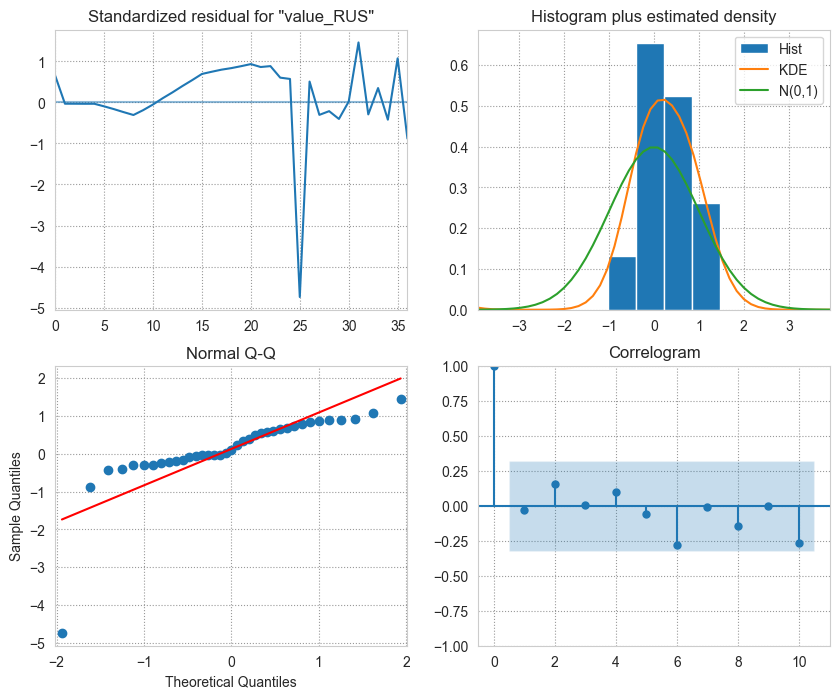

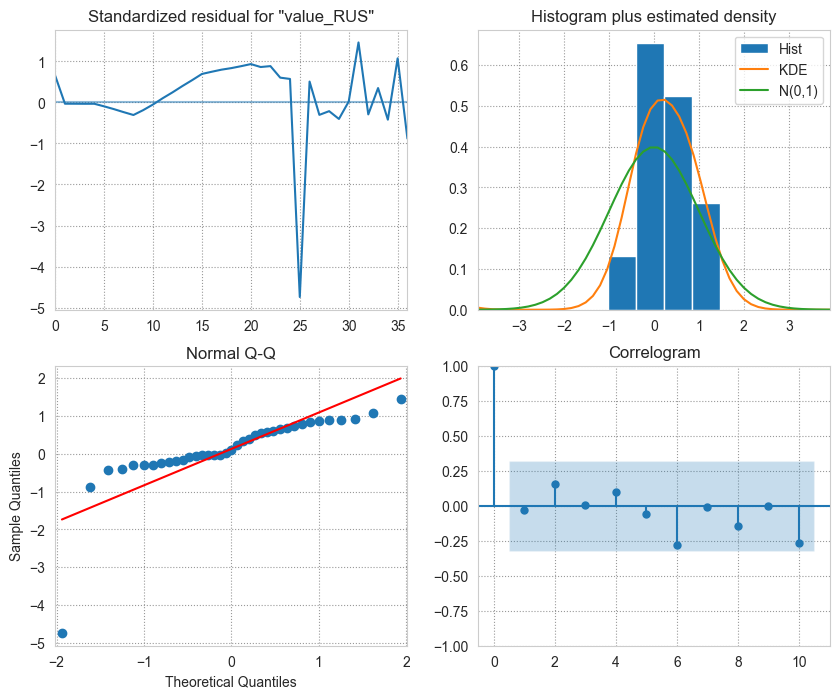

In [1188]:
model_fitted.plot_diagnostics(figsize=(10, 8))

In [1189]:
y_pred = forecast.iloc[:, 0].values
y_test = df['value_RUS'].iloc[-forecast_interval:]

MetricCalculator.show_regression_metrics(y_test, y_pred)

R²: -14.018
MAE: 0.06
MAPE: 0%
RMSE: 0
MSE: 0


In [1196]:
# Получаем остатки модели VARMAX
residuals = model_fitted.resid
rus_residuals = residuals['value_RUS']

In [1197]:
arch_test = het_arch(rus_residuals.dropna())
print(f"ARCH test p-value: {arch_test[1]:.4f}")

ARCH test p-value: 0.9998


## модель GARCH

In [1200]:
garch = arch_model(
    rus_residuals.dropna(), 
    mean='Zero', 
    vol='GARCH',
    p=1,
    q=1 
)

garch_fitted = garch.fit(update_freq=5, disp='on')
print(garch_fitted.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              value_RUS   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.027
Vol Model:                      GARCH   Log-Likelihood:                106.086
Distribution:                  Normal   AIC:                          -206.172
Method:            Maximum Likelihood   BIC:                          -201.339
                                        No. Observations:                   37
Date:                Mon, Apr 14 2025   Df Residuals:                       37
Time:                        17:33:24   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.8928e-04  1.850e-04      1.023      0.306 

C:\Users\Tikhon\Documents\PycharmProjects\PDA210\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001842. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
